## Background and Objective

### Background
Currently, the methods to calculate the speed and then classify the activity/cruising/movement type of a record (i.e. Dynamic Positioning (DP), Transit, etc) based on the vessel speed.

### Objective
The objective is to give a new idea or perspective on how we can classify the vessel activity.






Below is the statements to import all the library that needed for this model:

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance as gd

from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta

pd.options.mode.chained_assignment = None

### Data retrieval, data cleansing, data pre-processing
#### I downloaded the data from https://globalfishingwatch.org/ 
The data related to fishing vessel but I think the data format should be similar (AIS Data)

In [132]:
## Extract data from CSV file
## Later this data can be taken by stream it from AIS data provider 

df_pole_and_line = pd.read_csv("./data/pole_and_line.csv")

In [133]:
## convert the timestamp to date-time format
df_pole_and_line["date_time"] = df_pole_and_line['timestamp'].apply(datetime.utcfromtimestamp)

## convert meter to nautical mile (1 meter = 0.000539956803 nm)
df_pole_and_line['distance_from_port_nm']= df_pole_and_line['distance_from_port'] * 0.000539956803
df_pole_and_line['distance_from_shore_nm']= df_pole_and_line['distance_from_shore'] * 0.000539956803

#### Filter on 1 vessel, 1 year and limited area only (Vessel ID: 196184437994412)

In [134]:
## Query Data
## Limit the area based on longitude and latitude
df_vessel_1 = df_pole_and_line.loc[(df_pole_and_line['lon'] > 10 ) & 
                                  (df_pole_and_line['lat'] < 47 ) & 
                                  (df_pole_and_line['date_time'] >= "2016-01-01") & 
                                  (df_pole_and_line['mmsi'] == 196184437994412)]

df_vessel_1.reset_index(drop=True, inplace=True)
df_vessel_1.head(1)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,date_time,distance_from_port_nm,distance_from_shore_nm
0,1.961844e+14,1.452127e+09,0.0,1999.950928,0.0,137.5,33.511532,133.569061,-1.0,gfw,2016-01-07 00:34:13,1.079887,0.0


Below, I engineered the data and add information about previous coordinate of the vessel.

In [135]:
df_vessel_1['prev_lon'] = df_vessel_1.lon.shift(1)
df_vessel_1['prev_lat'] = df_vessel_1.lat.shift(1)

df_vessel_1['prev_coord'] = df_vessel_1.apply(lambda x: (x.prev_lat, x.prev_lon), axis=1)
df_vessel_1['curr_coord'] = df_vessel_1.apply(lambda x: (x.lat, x.lon), axis=1)

Using new data above, below I calculate distance traveled since previous point (current_coordinate - previous_coordinate):

In [136]:
# Here is the calculation of mile since the last record (current_coordinate - previous_coordinate)
df_vessel_1['mile_since'] = df_vessel_1.loc[df_vessel_1['prev_lon'].notnull()].apply(
    lambda x: gd.distance(x.prev_coord, x.curr_coord).nm, axis=1) 

# a clean the data from negative value, replace it with 0
df_vessel_1.at[(df_vessel_1['mile_since'] == -1), 'mile_since'] = 0

df_vessel_1[['prev_coord', 'curr_coord', 'mile_since']].head(2)

,prev_coord,curr_coord,mile_since
0,"(nan, nan)","(33.5115318298, 133.5690612793)",NaN
1,"(33.5115318298, 133.5690612793)","(33.5115318298, 133.5690917969)",0.001531


Next, I calculate the hour difference since previous point (current_time - previous_time):

In [137]:
# Here is the calculation of hour since the last record (current_time - previous_time)
# Then convert to hourly format
df_vessel_1['hour_since'] = (df_vessel_1.date_time - df_vessel_1.date_time.shift(1))/np.timedelta64(1, 'h')
df_vessel_1[['hour_since']].head(2)

,hour_since
0,NaN
1,0.108056


#### Generate 2 dummy columns related to  weather data: "is_storm" and "is_opposite_wind_direction"

In my opinion, although the values are simple and it doesn't represent the real data but it will add additional perspective for the machine learning model later on.

In [138]:
# is_storm is an over simplified of weather data, where I assume there are only two types (storm or calm)
df_vessel_1['is_storm'] = 0
df_vessel_1.at[df_vessel_1.index.isin(np.random.randint(0, 2181 + 1, size=100)), 'is_storm'] = 1


# is_opposite_wind_direction also an over simplified data, where I assume there are only two types
# (opposite or same direction)
df_vessel_1['is_opposite_wind_direction'] = 0
df_vessel_1.at[df_vessel_1.index.isin(np.random.randint(0, 2181 + 1, size=100)), 'is_opposite_wind_direction'] = 1

I also calculate speed based on previously calculated data:

In [139]:
# Here is the calculation of speed (mile_since - hour_since) --> nautical_mile/hour
df_vessel_1.at[(df_vessel_1['hour_since'] == 0) & (df_vessel_1['mile_since'] > 0), 'hour_since']=0.001

df_vessel_1['speed_nm'] = (df_vessel_1.mile_since / df_vessel_1.hour_since)

In [140]:
# fill the empty column with 0 to avoid error when train the model
df_vessel_1.fillna(0, inplace=True)

In [141]:
# delete some unused columns to save space
df_vessel_1 = df_vessel_1[['mmsi', 'speed', 'lat', 'lon', 'date_time',
                           'distance_from_port_nm', 'distance_from_shore_nm', 'curr_coord', 'mile_since', 'hour_since', 
                           'speed_nm', 'is_storm', 'is_opposite_wind_direction']]

In [142]:
df_vessel_1.head()

,mmsi,speed,lat,lon,date_time,distance_from_port_nm,distance_from_shore_nm,curr_coord,mile_since,hour_since,speed_nm,is_storm,is_opposite_wind_direction
0,1.961844e+14,0.0,33.511532,133.569061,2016-01-07 00:34:13,1.079887,0.0,"(33.5115318298, 133.5690612793)",0.000000,0.000000,0.000000,0,0
1,1.961844e+14,0.0,33.511532,133.569092,2016-01-07 00:40:42,1.079887,0.0,"(33.5115318298, 133.5690917969)",0.001531,0.108056,0.014169,0,0
2,1.961844e+14,0.0,33.511318,133.569168,2016-01-07 00:55:13,1.079887,0.0,"(33.5113182068, 133.5691680908)",0.013354,0.241944,0.055194,0,0
3,1.961844e+14,0.0,33.511402,133.569046,2016-01-07 01:22:10,1.079887,0.0,"(33.5114021301, 133.5690460205)",0.007922,0.449167,0.017638,0,0
4,1.961844e+14,0.0,33.511429,133.569092,2016-01-07 01:28:06,1.079887,0.0,"(33.511428833000004, 133.5690917969)",0.002798,0.098889,0.028299,0,0


## Scale the data and train the ML model
The data needs to be scaled, because the variance is quite high, for instance "distance_from_port_nm" has values that range from 0 to 730. 
For this, I use Robust-Scaler from Scikit-learn because it will scaled the data and decreased the advantages of having outliers data.

Then, I arrange the features which the model will be trained with. This features will be the main parameter for the ML model. Currently there are seven features.

In [143]:
df_vessel_1.distance_from_port_nm.max()

730.0200452801914

In [144]:
from sklearn.preprocessing import RobustScaler


# Features preparation. Copy from the original dataframe to a variable.
X = df_vessel_1[['distance_from_port_nm', 'distance_from_shore_nm', 
                 'mile_since', 'speed', 
                 'hour_since', 'is_storm', 
                 'is_opposite_wind_direction']]

# Variable X then fitted to the scaler
scaler = RobustScaler().fit(X)

# Then Transform the X into array X_scaled, this variable later will be the parameter for model
X_scaled = scaler.transform(X)

# Below is the sample data before scaled:
X.head(2)

,distance_from_port_nm,distance_from_shore_nm,mile_since,speed,hour_since,is_storm,is_opposite_wind_direction
0,1.079887,0.0,0.000000,0.0,0.000000,0,0
1,1.079887,0.0,0.001531,0.0,0.108056,0,0


Below is the sampe data after scaled:

In [145]:
X_scaled[0:2]

array([[-0.08427391, -0.09160519, -0.5914415 , -1.12621361, -0.62373737,
         0.        ,  0.        ],
       [-0.08427391, -0.09160519, -0.59108982, -1.12621361, -0.37815657,
         0.        ,  0.        ]])

###  Train the model

The model it self is K-means, an unsupervised method to train machine learning model. The model creates clusters by calculating  the distance in multi-dimension data (in this case, it calculates seven dimensions data) and group points that close to each other.

Parameters that are set for the models:

n_clusters -> How many clusters that will produces by the model 

n_init -> How many central point that this model will run in parallel. In the end, it will choose the best of n.

max_iter -> How many iteration for a single run. 

In [146]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(
    n_clusters=6, 
    n_init=20, # The default is 10, increased it to 20
    max_iter=500 # The default is 300, increased it to 500
)

kmeans_y_result = km.fit_predict(X_scaled)

Below, I add new column to the original vessel dataframe and copy the result in to the column.

In [147]:
df_vessel_1['group'] = kmeans_y_result

In [153]:
df_vessel_1.loc[[128, 4, 318, 1507, 2123, 1048], 
                ['distance_from_port_nm', 
                 'speed', 'distance_from_shore_nm', 
                 'speed_nm', 'mile_since', 'hour_since', 'is_storm', 'is_opposite_wind_direction', 'group']]

,distance_from_port_nm,speed,distance_from_shore_nm,speed_nm,mile_since,hour_since,is_storm,is_opposite_wind_direction,group
128,473.666846,7.5,205.116732,8.862434,814.373952,91.890556,0,0,0
4,1.079887,0.0,0.000000,0.028299,0.002798,0.098889,0,0,4
318,511.279798,12.5,25.651580,11.114439,422.796338,38.040278,0,0,2
1507,130.594923,12.0,10.258927,1.150373,56.735118,49.318889,0,0,3
2123,26.850997,11.2,16.877015,0.684036,12.474158,18.236111,1,0,1
1048,272.140659,13.6,259.045204,1.413554,677.989006,479.634444,0,0,5


Below is the distribution of each group. The higher number of member is group 4 which I can classify as stop/hover or "DP" event:

In [149]:
df_vessel_1.groupby('group').count()['mmsi']

group
0      12
1     143
2      37
3      15
4    1968
5       6
Name: mmsi, dtype: int64

### Plot the vessel on the map based on latitude and longitude

In [154]:
# for practicality I copy the data from the original Dataframe
df_vessel_plot_1 = df_vessel_1

# then split it into 6 group, as many as number of group from model training 
df_vessel_plot_group_0 = df_vessel_plot_1.loc[df_vessel_plot_1['group'] == 0]
df_vessel_plot_group_1 = df_vessel_plot_1.loc[df_vessel_plot_1['group'] == 1]
df_vessel_plot_group_2 = df_vessel_plot_1.loc[df_vessel_plot_1['group'] == 2]
df_vessel_plot_group_3 = df_vessel_plot_1.loc[df_vessel_plot_1['group'] == 3]
df_vessel_plot_group_4 = df_vessel_plot_1.loc[df_vessel_plot_1['group'] == 4]
df_vessel_plot_group_5 = df_vessel_plot_1.loc[df_vessel_plot_1['group'] == 5]

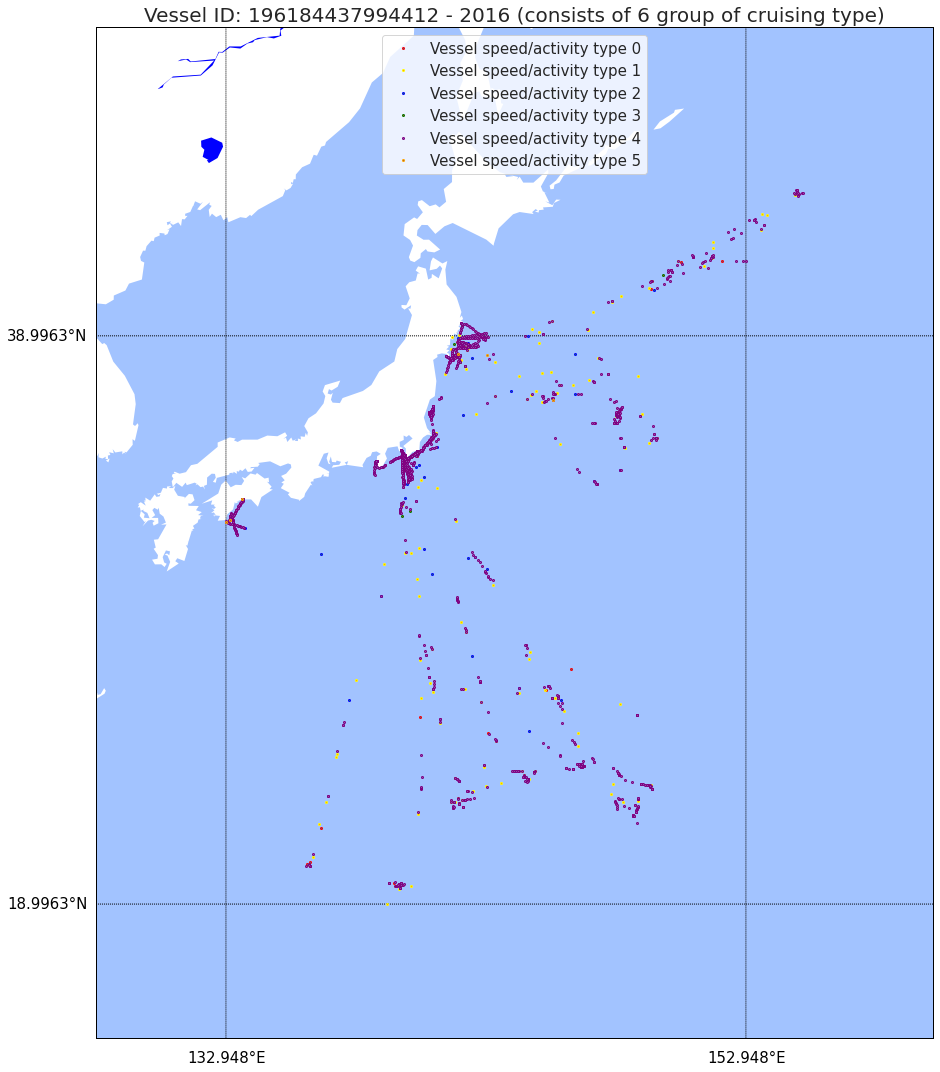

In [155]:
sns.set_style("white")
plt.figure(figsize=(15, 25)) 

## Create a map object using the lowest and the highest longitude and latitude value of the data. 
## Then give spare 5 degree for each side to give more room.
m = Basemap(llcrnrlon=df_vessel_plot_1.lon.min()-5,llcrnrlat=df_vessel_plot_1.lat.min()-5,
            urcrnrlon=df_vessel_plot_1.lon.max()+5,urcrnrlat=df_vessel_plot_1.lat.max()+5,projection='mill', resolution ='l')

# This will draw both the boundary and lines
# This draw the boundary that separate the map object (sea, soil, etc.)
m.drawmapboundary()
m.fillcontinents("white",lake_color="blue")
parallels = np.arange(df_vessel_plot_1.lat.min(),df_vessel_plot_1.lat.max(),20.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=15,color='black')
meridians = np.arange(df_vessel_plot_1.lon.min(),df_vessel_plot_1.lon.max(),20.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15,color='black')
m.drawmapboundary(fill_color='#A2C3FF')

## Group 0
## Based on data that has been clustered before. Take longitude and latitude from df_vessel_plot_group_0 then give a red color 
x,y= m(df_vessel_plot_group_0.lon.to_numpy(),df_vessel_plot_group_0.lat.to_numpy())
size = 2
m.plot(x,y,marker = 'o',markersize=size,markeredgecolor = 'red',
       alpha = 1,linestyle='None', label="Vessel speed/activity type 0")

## Group 1
## Based on data that has been clustered before. 
## Take longitude and latitude from df_vessel_plot_group_1, set the point size, give label then give a yellow color
x,y= m(df_vessel_plot_group_1.lon.to_numpy(),df_vessel_plot_group_1.lat.to_numpy())
m.plot(x,y,marker = 'o',markersize=2,markeredgecolor = 'yellow',
       alpha = 1,linestyle='None', label="Vessel speed/activity type 1")

## Group 2
## Based on data that has been clustered before. 
## Take longitude and latitude from df_vessel_plot_group_2, set the point size, give label then give a yellow blue
x,y= m(df_vessel_plot_group_2.lon.to_numpy(),df_vessel_plot_group_2.lat.to_numpy())
m.plot(x,y,marker = 'o',markersize=2,markeredgecolor = 'blue',
       alpha = 1,linestyle='None', label="Vessel speed/activity type 2")

## Group 3
## Based on data that has been clustered before. 
## Take longitude and latitude from df_vessel_plot_group_3, set the point size, give label then give a green color
x,y= m(df_vessel_plot_group_3.lon.to_numpy(),df_vessel_plot_group_3.lat.to_numpy())
m.plot(x,y,marker = 'o',markersize=2,markeredgecolor = 'green',
       alpha = 1,linestyle='None', label="Vessel speed/activity type 3")

## Group 4
## Based on data that has been clustered before. 
## Take longitude and latitude from df_vessel_plot_group_4, set the point size, give label then give a purple color
x,y= m(df_vessel_plot_group_4.lon.to_numpy(),df_vessel_plot_group_4.lat.to_numpy())
m.plot(x,y,marker = 'o',markersize=2,markeredgecolor = 'purple',
       alpha = 1,linestyle='None', label="Vessel speed/activity type 4")

## Group 5
## Based on data that has been clustered before. 
## Take longitude and latitude from df_vessel_plot_group_5, set the point size, give label then give a orange color
x,y= m(df_vessel_plot_group_5.lon.to_numpy(),df_vessel_plot_group_5.lat.to_numpy())
m.plot(x,y,marker = 'o',markersize=2,markeredgecolor = 'orange',
       alpha = 1,linestyle='None', label="Vessel speed/activity type 5")


## This is the title of the Map
plt.title("Vessel ID: 196184437994412 - 2016 (consists of 6 group of cruising type)", 
         fontsize=20)
plt.legend(fontsize=15)
plt.show()

Using this approach it is possible to put several variables into consideration to predict activity of a vessel at a point of time.<br>
From the clusters we can see that: <br>
- The algorithm can put "DP" or stop event into one cluster (Group 4 / color code in purple) 
- It can also separate almost all transit (higher speed) event into several clusters ( Group 1 /  color code in yellow)
- It can also sense if the AIS data was coming after a long time (Group 0 and 2 / color code in red and blue) 

I am confidence, with some more tuning the model can give a better output and room for feature enhancement. 

## Potential Future Enhancement and Improvement

Potential Enhancement: <br>
- Engineer a feature to get a heading/direction data of a vessel. I think direction can be calculated by using "previous_coordinate" and "current_coordinate". Then, we can make analysis about circling vessel movement by grouping several records inside a range of time.
- Develop two micro-service, one is for data preprocessing and the other one is for execute ML models.

My ideas for enhancement in near future (2 weeks until 2 months) are: <br>
- Build similar model like this for each similar vessel specification then use it to label the current data. Finally use it to train a supervised method to do prediction directly.
- Group all previous route by origin, destination and vessel type. The company with help from a domain expert can do some reinforcement learning to evaluate/weighing the best route possible.
- Enhance the usage of weather data.

For enhancement in far future (more than 6 months): <br>
- Develop a sea traffic analysis to get a better insight for journey planning. For example, By tracking the vessels which on the way to a port, an algorithm can predict when is a better time to start the journey to avoid or reduce queing and waiting time.

Unfortunately, I didn't use a real supply vessel AIS data, I also didn't find any engine and fuel consumption data.
